In [1]:
# Environment setup function
def setup_spark_environment():
    # Install dependencies
    !apt-get install openjdk-8-jdk-headless -qq > /dev/null
    !wget -q https://archive.apache.org/dist/spark/spark-3.5.4/spark-3.5.4-bin-hadoop3.tgz
    !tar xf spark-3.5.4-bin-hadoop3.tgz
    !pip install -q findspark

    # Set environment variables
    import os
    os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
    os.environ["SPARK_HOME"] = "/content/spark-3.5.4-bin-hadoop3"

    # Initialize findspark
    import findspark
    findspark.init()

    # Create Spark session
    from pyspark.sql import SparkSession
    spark = SparkSession.builder.appName("GoldPricePrediction").getOrCreate()

    return spark

# Call setup function
spark = setup_spark_environment()

#Task 2.2

Dataset preview:
+----------+---------+----------+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+
|      Date|Buy Price|Sell Price|lag_1|lag_2|lag_3|lag_4|lag_5|lag_6|lag_7|lag_8|lag_9|lag_10|
+----------+---------+----------+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+
|2009-08-11|    21.13|     21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19| 21.19|
|2009-08-12|    21.13|     21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19| 21.19|
|2009-08-13|    21.13|     21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19| 21.19|
|2009-08-14|    21.13|     21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19| 21.19|
|2009-08-15|    21.13|     21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19| 21.19|
+----------+---------+----------+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+
only showing top 5 rows

Training set size: 3964
Test set size: 1591
Training model...
Training RMSE: 0.4943
Test RMSE: 0.4076
T

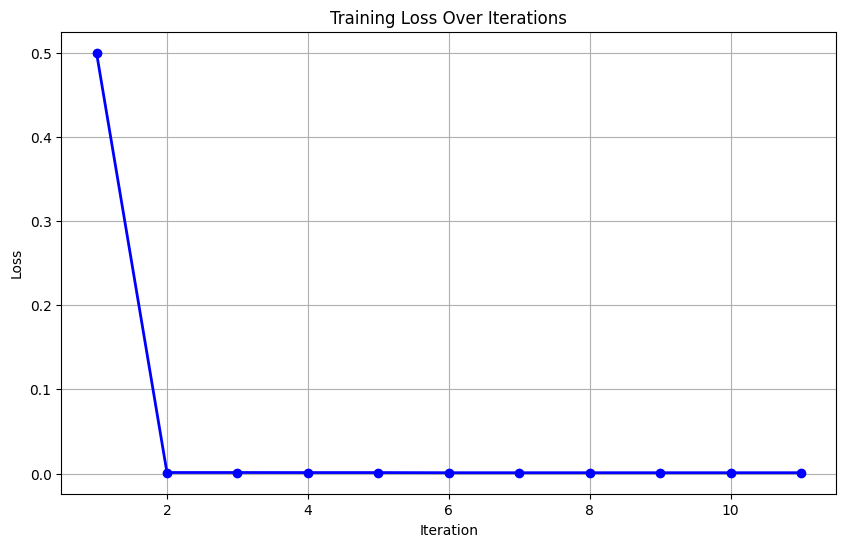

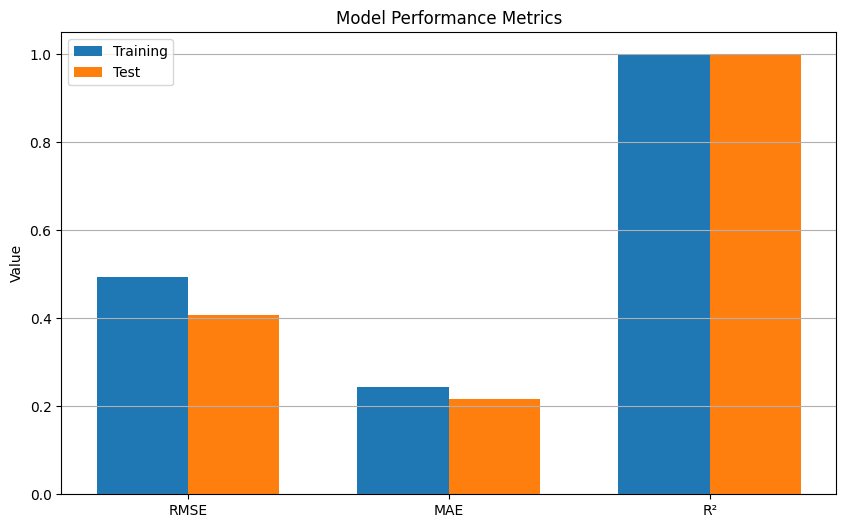

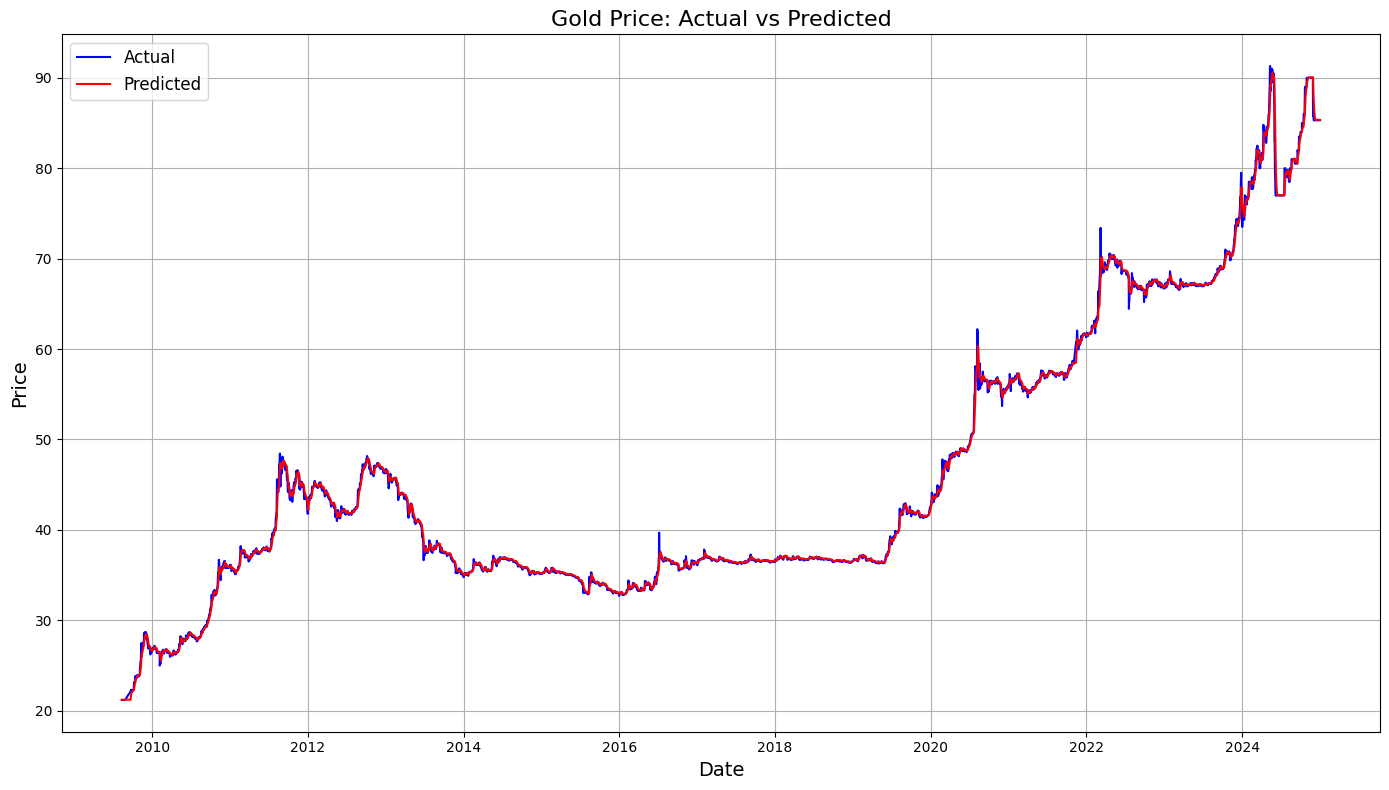

In [16]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lag
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Create a Spark session with optimized configuration
spark = SparkSession.builder \
    .appName("Gold Price Prediction") \
    .getOrCreate()

# Function to load and preprocess data
def load_and_preprocess_data(file_path):
    # Read gold price data
    df = spark.read.csv(file_path, header=True, inferSchema=True)
    df = df.withColumn("Date", col("Date").cast("date")).orderBy("Date")

    # Use window functions to create lag features efficiently
    windowSpec = Window.orderBy("Date")
    feature_df = df

    # Create all lag features in a single pass
    for i in range(1, 11):
        feature_df = feature_df.withColumn(f"lag_{i}", lag("Sell Price", i).over(windowSpec))

    # Cache the dataframe to speed up subsequent operations
    feature_df = feature_df.na.drop().cache()

    return feature_df

# Function to create feature vectors and split data
def prepare_ml_data(feature_df):
    # Create feature vector
    feature_cols = [f"lag_{i}" for i in range(1, 11)]
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

    # Select only the needed columns to reduce memory usage
    data = feature_df.select("Date", *feature_cols, col("Sell Price").alias("label"))

    # Create ML pipeline to optimize transformations
    pipeline = Pipeline(stages=[assembler])
    pipeline_model = pipeline.fit(data)
    vector_data = pipeline_model.transform(data).select("Date", "features", "label")

    # Cache the transformed data for faster training and evaluation
    vector_data.cache()

    # Split data into training and test sets (70:30)
    train_data, test_data = vector_data.randomSplit([0.7, 0.3], seed=42)

    return train_data, test_data, vector_data

# Function to train and evaluate the model
def train_and_evaluate_model(train_data, test_data):
    # Configure LinearRegression with optimized parameters
    lr = LinearRegression(
        featuresCol="features",
        labelCol="label",
        maxIter=20,
        regParam=0.1,
        elasticNetParam=0.0,
        standardization=True,
        solver="l-bfgs",
        tol=1e-6,  # Tighter convergence tolerance
        aggregationDepth=2  # Increase for better parallelism
    )

    # Train model
    print("Training model...")
    model = lr.fit(train_data)

    # Get training summary
    summary = model.summary

    # Evaluate on test data using a single evaluator instance
    evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label")

    # Calculate metrics for training data
    train_predictions = model.transform(train_data)
    train_rmse = evaluator.setMetricName("rmse").evaluate(train_predictions)
    train_mae = evaluator.setMetricName("mae").evaluate(train_predictions)
    train_r2 = evaluator.setMetricName("r2").evaluate(train_predictions)

    # Calculate metrics for test data
    test_predictions = model.transform(test_data)
    test_rmse = evaluator.setMetricName("rmse").evaluate(test_predictions)
    test_mae = evaluator.setMetricName("mae").evaluate(test_predictions)
    test_r2 = evaluator.setMetricName("r2").evaluate(test_predictions)

    metrics = {
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2
    }

    return model, summary, metrics

# Function to create visualizations
def create_visualizations(model, summary, metrics, vector_data):
    # 1. Plot training loss over iterations
    loss_history = summary.objectiveHistory

    plt.figure(figsize=(10, 6))
    if len(loss_history) > 1:
        plt.plot(range(1, len(loss_history) + 1), loss_history, 'bo-', linewidth=2)
    else:
        plt.scatter([1], loss_history, color='blue', s=100)
        plt.xlim(0, 2)

    plt.title("Training Loss Over Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

    # 2. Bar chart for metrics comparison
    metric_names = ['RMSE', 'MAE', 'R²']
    train_values = [metrics['train_rmse'], metrics['train_mae'], metrics['train_r2']]
    test_values = [metrics['test_rmse'], metrics['test_mae'], metrics['test_r2']]

    x = np.arange(len(metric_names))
    width = 0.35

    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, train_values, width, label='Training')
    plt.bar(x + width/2, test_values, width, label='Test')
    plt.ylabel('Value')
    plt.title('Model Performance Metrics')
    plt.xticks(x, metric_names)
    plt.legend()
    plt.grid(axis='y')
    plt.show()

    # 3. Generate predictions for visualization
    # Convert to pandas efficiently by selecting only needed columns
    all_predictions = model.transform(vector_data).select("Date", "label", "prediction")

    # Collect results to driver with reasonable size (potentially sampling for very large datasets)
    if all_predictions.count() > 10000:
        all_predictions_pd = all_predictions.sample(False, 10000/all_predictions.count()).toPandas()
    else:
        all_predictions_pd = all_predictions.toPandas()

    all_predictions_pd = all_predictions_pd.sort_values(by="Date")

    # Create actual vs predicted plot
    plt.figure(figsize=(14, 8))
    plt.plot(all_predictions_pd["Date"], all_predictions_pd["label"], 'b-', linewidth=1.5, label='Actual')
    plt.plot(all_predictions_pd["Date"], all_predictions_pd["prediction"], 'r-', linewidth=1.5, label='Predicted')
    plt.title('Gold Price: Actual vs Predicted', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Price', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Main execution
def main():
    # Load and preprocess data
    feature_df = load_and_preprocess_data("gold_prices.csv")
    print("Dataset preview:")
    feature_df.show(5)

    # Prepare ML data
    train_data, test_data, vector_data = prepare_ml_data(feature_df)
    print(f"Training set size: {train_data.count()}")
    print(f"Test set size: {test_data.count()}")

    # Train and evaluate model
    model, summary, metrics = train_and_evaluate_model(train_data, test_data)
    print(f"Training RMSE: {metrics['train_rmse']:.4f}")
    print(f"Test RMSE: {metrics['test_rmse']:.4f}")
    print(f"Training R²: {metrics['train_r2']:.4f}")
    print(f"Test R²: {metrics['test_r2']:.4f}")

    # Create visualizations
    create_visualizations(model, summary, metrics, vector_data)

    # Clean up
    vector_data.unpersist()
    feature_df.unpersist()
    spark.stop()

if __name__ == "__main__":
    main()

#Task 3

Preparing data...
Dataset preview:
+----------+---------+----------+
|      Date|Buy Price|Sell Price|
+----------+---------+----------+
|2009-08-01|    21.13|     21.19|
|2009-08-02|    21.13|     21.19|
|2009-08-03|    21.13|     21.19|
|2009-08-04|    21.13|     21.19|
|2009-08-05|    21.13|     21.19|
+----------+---------+----------+
only showing top 5 rows

Features created. Sample data:
+----------+---------+----------+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+
|      Date|Buy Price|Sell Price|lag_1|lag_2|lag_3|lag_4|lag_5|lag_6|lag_7|lag_8|lag_9|lag_10|
+----------+---------+----------+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+
|2009-08-11|    21.13|     21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19| 21.19|
|2009-08-12|    21.13|     21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19| 21.19|
|2009-08-13|    21.13|     21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19|21.19| 21.19|
|2009-08-14|    21.13|     21.19|

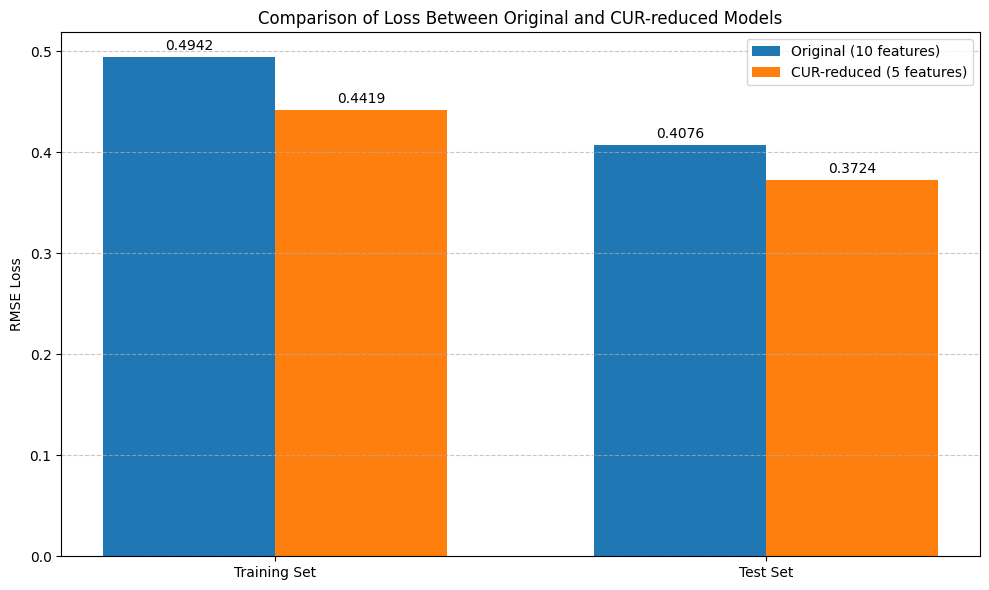

In [21]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lag, udf, array
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# For CUR Decomposition
from pyspark.mllib.linalg import Vectors, DenseVector
from pyspark.ml.linalg import VectorUDT  # Import VectorUDT here - this is the missing import
from pyspark.sql.types import ArrayType, DoubleType
import random

# Create a Spark session with more memory
spark = SparkSession.builder \
    .appName("Gold Price Prediction with CUR") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

# Define the improved CUR decomposition class
class CUR_Decomposition:
    """
    Class implementing the CUR decomposition for dimensionality reduction.
    """

    def __init__(self, target_dim=5, seed=42):
        """
        Initialize CUR decomposition.

        Parameters:
        -----------
        target_dim : int
            Target dimensionality after reduction (default 5)
        seed : int
            Random seed for reproducibility
        """
        self.target_dim = target_dim
        self.seed = seed
        self.column_indices = None
        random.seed(seed)

    def fit(self, data):
        """
        Fit the CUR decomposition by selecting important columns.

        Parameters:
        -----------
        data : DataFrame
            Spark DataFrame with features column containing dense vectors

        Returns:
        -----------
        self : object
            Returns self
        """
        # Create a UDF to extract features from vector
        @udf(returnType=ArrayType(DoubleType()))
        def extract_features(vector):
            return vector.toArray().tolist() if vector else None

        # Extract features to array column for analysis
        features_df = data.withColumn("feature_array", extract_features(col("features")))

        # Cache for better performance
        features_df.cache()

        # Convert to pandas for easier statistical analysis
        # We'll only take a sample if the data is very large
        if features_df.count() > 10000:
            pandas_df = features_df.sample(False, 10000/features_df.count(), seed=self.seed).toPandas()
        else:
            pandas_df = features_df.toPandas()

        # Calculate variance for each feature
        feature_arrays = np.stack(pandas_df['feature_array'].values)
        variances = np.var(feature_arrays, axis=0)

        # Create pairs of (index, variance)
        variance_pairs = [(i, var) for i, var in enumerate(variances)]

        # Sort by variance in descending order
        sorted_pairs = sorted(variance_pairs, key=lambda x: x[1], reverse=True)

        # Select top target_dim columns
        self.column_indices = [idx for idx, _ in sorted_pairs[:self.target_dim]]

        # Unpersist the cached DataFrame
        features_df.unpersist()

        print(f"Selected columns (by variance): {self.column_indices}")
        print(f"Corresponding variances: {[sorted_pairs[i][1] for i in range(self.target_dim)]}")

        return self

    def transform(self, data):
        """
        Transform data to reduced dimensionality by selecting columns.

        Parameters:
        -----------
        data : DataFrame
            Spark DataFrame with features column containing dense vectors

        Returns:
        -----------
        DataFrame
            DataFrame with reduced features
        """
        if self.column_indices is None:
            raise ValueError("CUR decomposition not fitted yet")

        from pyspark.ml.linalg import Vectors as MLVectors  # Import within function

        # Create a UDF to extract features from vector
        @udf(returnType=ArrayType(DoubleType()))
        def extract_features(vector):
            return vector.toArray().tolist() if vector else None

        # Create a UDF to select specific columns
        @udf(returnType=ArrayType(DoubleType()))
        def select_columns(feature_array):
            if feature_array is None:
                return None
            return [feature_array[i] for i in self.column_indices]

        # Create a UDF to convert array back to vector
        @udf(returnType=VectorUDT())
        def to_vector(array):
            if array is None:
                return None
            return MLVectors.dense(array)

        # Apply the transformations
        result_df = data \
            .withColumn("feature_array", extract_features(col("features"))) \
            .withColumn("selected_features", select_columns(col("feature_array"))) \
            .withColumn("features_cur", to_vector(col("selected_features"))) \
            .select("Date", col("features_cur").alias("features"), "label")

        return result_df

# Function to load and preprocess data
def prepare_data():
    # Read gold price data
    df = spark.read.csv("gold_prices.csv", header=True, inferSchema=True)
    df = df.withColumn("Date", col("Date").cast("date")).orderBy("Date")

    print("Dataset preview:")
    df.show(5)

    # Use window functions to create lag features
    windowSpec = Window.orderBy("Date")
    feature_df = df

    for i in range(1, 11):
        feature_df = feature_df.withColumn(f"lag_{i}", lag("Sell Price", i).over(windowSpec))

    # Drop rows with null values (first 10 rows)
    feature_df = feature_df.na.drop()

    print("Features created. Sample data:")
    feature_df.show(5)

    # Create feature vector
    feature_cols = [f"lag_{i}" for i in range(1, 11)]
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    vector_df = assembler.transform(feature_df).select("Date", "features", col("Sell Price").alias("label"))

    # Cache the dataframe to improve performance
    vector_df.cache()

    # Force computation to ensure caching works
    print(f"Total rows in dataset: {vector_df.count()}")

    # Split data into training and test sets (70:30)
    train_data, test_data = vector_df.randomSplit([0.7, 0.3], seed=42)

    return train_data, test_data

# Function to train and evaluate a model
def train_and_evaluate(train_data, test_data, name="Model"):
    # Configure LinearRegression
    lr = LinearRegression(
        featuresCol="features",
        labelCol="label",
        maxIter=20,
        regParam=0.1,
        elasticNetParam=0.0,
        standardization=True,
        solver="normal"  # Use normal equations solver which is more stable
    )

    # Train model
    print(f"Training {name}...")
    model = lr.fit(train_data)
    summary = model.summary
    train_loss = summary.rootMeanSquaredError

    # Evaluate on test data
    test_evaluation = model.evaluate(test_data)
    test_loss = test_evaluation.rootMeanSquaredError

    print(f"{name} Training RMSE: {train_loss}")
    print(f"{name} Test RMSE: {test_loss}")

    return model, summary, train_loss, test_loss

def main():
    try:
        # Prepare data
        print("Preparing data...")
        train_data, test_data = prepare_data()

        print(f"Original training set size: {train_data.count()}")
        print(f"Original test set size: {test_data.count()}")

        # Train and evaluate on original data
        original_model, original_summary, original_train_loss, original_test_loss = train_and_evaluate(
            train_data, test_data, name="Original Model"
        )

        # Initialize and fit CUR decomposition
        print("Initializing CUR decomposition...")
        cur = CUR_Decomposition(target_dim=5, seed=42)

        print("Fitting CUR decomposition...")
        cur.fit(train_data)

        # Transform data using CUR
        print("Transforming data with CUR...")
        train_data_cur = cur.transform(train_data)
        test_data_cur = cur.transform(test_data)

        print("CUR-reduced data sample:")
        train_data_cur.select("features").show(1, truncate=False)

        # Check transformed data
        print(f"CUR-reduced training set size: {train_data_cur.count()}")
        print(f"CUR-reduced test set size: {test_data_cur.count()}")

        # Train and evaluate on CUR-reduced data
        cur_model, cur_summary, cur_train_loss, cur_test_loss = train_and_evaluate(
            train_data_cur, test_data_cur, name="CUR-reduced Model"
        )

        # Compare losses with bar chart
        datasets = ['Training Set', 'Test Set']
        original_losses = [original_train_loss, original_test_loss]
        cur_losses = [cur_train_loss, cur_test_loss]

        # Set up the bar chart
        x = np.arange(len(datasets))
        width = 0.35

        # Create plot
        plt.figure(figsize=(10, 6))
        bars1 = plt.bar(x - width/2, original_losses, width, label='Original (10 features)')
        bars2 = plt.bar(x + width/2, cur_losses, width, label='CUR-reduced (5 features)')

        # Add labels and title
        plt.ylabel('RMSE Loss')
        plt.title('Comparison of Loss Between Original and CUR-reduced Models')
        plt.xticks(x, datasets)
        plt.legend()

        # Add value labels on top of bars
        def add_labels(bars):
            for bar in bars:
                height = bar.get_height()
                plt.annotate(f'{height:.4f}',
                           xy=(bar.get_x() + bar.get_width() / 2, height),
                           xytext=(0, 3),  # 3 points vertical offset
                           textcoords="offset points",
                           ha='center', va='bottom')

        add_labels(bars1)
        add_labels(bars2)

        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error: {str(e)}")
        import traceback
        traceback.print_exc()
    finally:
        # Stop Spark session
        spark.stop()

if __name__ == "__main__":
    main()